C:\Users\Eti\git\MaschinellesLernen\A2


Number of persons parsed: 294984
(7484, 1024)


ValueError: cannot reshape array of size 3 into shape (32,32)

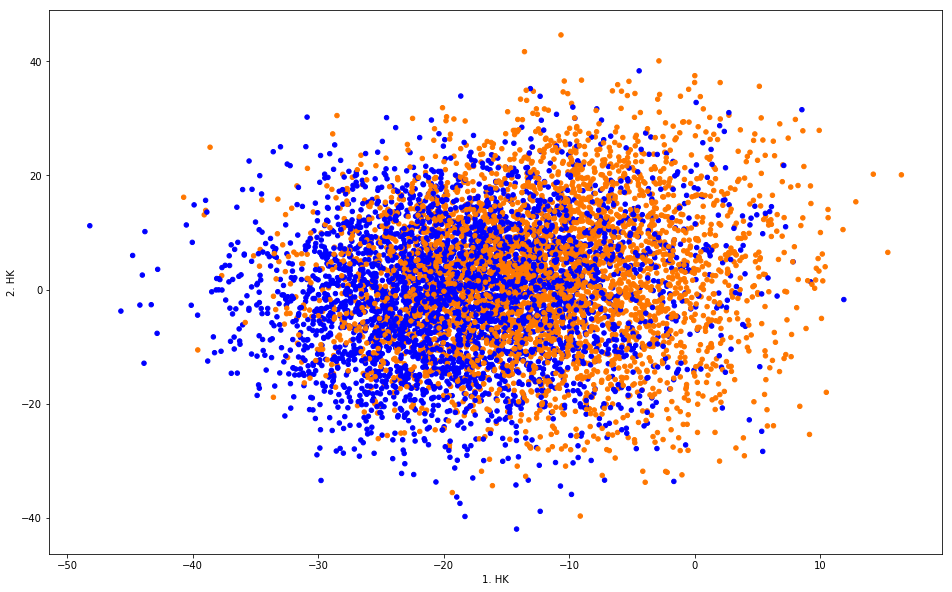

In [2]:
import os
import urllib.request
import tarfile

if not os.path.isfile("lfw-funneled.tgz"):
    print("Downloading: " + url)
    urllib.request.urlretrieve("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", "lfw-funneled.tgz")
if not os.path.isdir("lfw-funneled"):
    tar = tarfile.open("lfw-funneled.tgz", "r:gz")
    tar.extractall()
    tar.close()

import os
import glob
from skimage import io, color, transform
import skimage
import numpy as np
import matplotlib
import pandas


def image_crop_to_square(image):  # expects greyscale image
    height, width = image.shape
    if height > width:
        offset = int(round(((height-width)/2)))
        image = image[offset:height-offset, 0:width]
    else:
        offset = int(round(((width-height)/2)))
        image = image[0:height, offset:width-offset]
    return image


def image_crop_face(image):  # expects greyscale image
    height, width = image.shape
    if not height == width:
        print("Image is not suqare!")
    else:
        fourth = int(round(height/4))
        end = fourth*3
        return image[fourth:end, fourth:end]


def image_scale_to_32x32(image):  # expects greyscale image
    return transform.resize(image, (32, 32))


def stack_image(image):
    return np.reshape(image, -1)


def unstack_image(image):
    return np.reshape(image, (32, 32))


def hauptkomponentenanalyse(data):
    data = data - data.mean()
    data = data / data.std()
    return np.linalg.svd(data, full_matrices=False)


def getColor(v, md):
    if v > md:
        return '#FF7700' 
    else:
        return '#0000FF'


def image_to_32x32_gray(image_path):
    image = io.imread(image_path)
    image = color.rgb2gray(image)
    cropped = image_crop_to_square(image)
    cropped = image_crop_face(cropped)
    cropped = image_scale_to_32x32(cropped)
    return cropped


print(os.getcwd())

array = []
persons = {}
testbilder = {}
os.chdir("lfw_funneled")
dirs = glob.glob("*/")      # List all directories
for current_dir in dirs:    # Get all filenames in all directories
    person_images = []
    os.chdir(current_dir)
    # Read in all except one image in each dir
    images = glob.glob("*.jpg")
    test_image = images.pop(0)
    test_image = image_to_32x32_gray(test_image)
    testbilder[current_dir] = test_image
    for img in images:
        cropped = image_to_32x32_gray(img)
        person_images.append(cropped)
        array.append(stack_image(cropped))
    persons[current_dir] = person_images
    os.chdir("../")
os.chdir("../")
print("Number of persons parsed: " + str(persons.__sizeof__()))
to_nd_array = np.array(array)
print(to_nd_array.shape)

# Aufgabe 2.2c
[u, d, v] = hauptkomponentenanalyse(to_nd_array)
projection = np.dot(u, np.diag(d))[:, [0, 1, 2]]
points = pandas.DataFrame(projection).iloc[:,[0, 1]]

# Scatter plot
%matplotlib inline
pointsDf = pandas.DataFrame(points.values, columns=["1. HK", "2. HK"])

tgtCol = pandas.DataFrame(to_nd_array).iloc[:,-1]
md = tgtCol.median()

colors = list(map(lambda x: getColor(x, md), tgtCol))

pointsDf.plot.scatter(0, 1, c=colors, figsize=(16, 10))

print(type(projection))
# Eigengesichter
for i in range(1, 12):
    print(type(projection[i]))
    unstacked = unstack_image(projection[i])
    # Show image
    skimage.io.imshow(unstacked)
